# Описание проекта 
Данные получены от стартапа, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи мобильного приложения. Для этого необходимо изучить воронку и провести анализ результатов А/А/В-теста.

Описание данных:
Каждая запись в логе — это действие пользователя, или событие. 
EventName — название события;
DeviceIDHash — уникальный идентификатор пользователя;
EventTimestamp — время события;
ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.
Проект пройдет в несколько этапов:
1. Подготовка данных для дальнейшего исследования.
2. Изучение и проверка данных
3. Построение воронки событий 
4. Анализ результатов А/А/В эксперимента

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats as st
import math as mth
from plotly import graph_objects as go

## Подготовка данных

In [2]:
# Откроем файл
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')


In [3]:
display(data.head())
data.info()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Пропусков в данных нет

In [4]:
# Переименуем столбцы
data.columns = ['event_name', 'user_id', 'event_dt', 'group']

In [5]:
# Проверим на явные дупликаты
data.duplicated().sum()

413

Выявленные дупликаты составляют около 0.17% от общего объема, поэтому их можно удалить без искажения данных.

In [6]:
# Удалим дупликаты
data = data.drop_duplicates().reset_index(drop=True)

In [7]:
# Переведем столбец со временем события к необходимому типу
data['event_dt'] = pd.to_datetime(data['event_dt'], unit='s')

In [8]:
# Добавим столбец с датой события
data['date'] = pd.to_datetime(data['event_dt'].dt.date)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_dt    243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


In [10]:
data.head()

,event_name,user_id,event_dt,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


На первом этапе обработали данные для дальнейщего исследования. Переименовали столбцы датафрейма в удоюные для понимания, удалили явные дупликаты и превели к требуемому типу данных сталбцы с датой.

## Проверка данных

In [11]:
# Выведем и посчитаем уникальные события
display(data['event_name'].nunique())
data['event_name'].unique()

5

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [12]:
# Посчитаем уникальных пользователей
data['user_id'].nunique()

7551

In [13]:
# Посчитаем сколько в среднем событий приходится на одного пользователя
data.groupby('user_id').agg({'event_name':'count'}).median()

event_name    20.0
dtype: float64

Посчитаем медианное значение, так как присутсвуют вбросы, которые могут повлиять на расчитываемое значение. В среднем на одного пользователя приходится 20 событий.

In [14]:
# Вывудем самую ранюю и позднюю дату
display(data['date'].min())
data['date'].max()

Timestamp('2019-07-25 00:00:00')

Timestamp('2019-08-07 00:00:00')

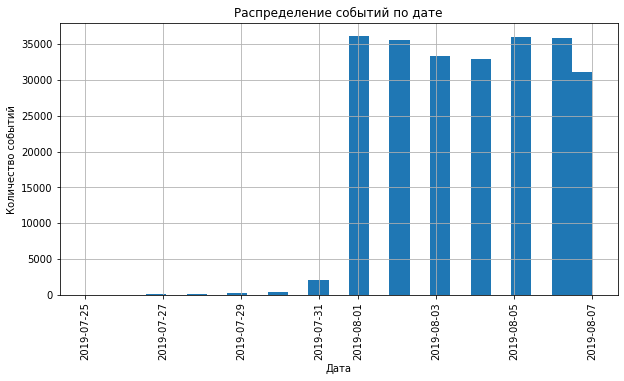

In [15]:
# Построи гистограму с распределением событий по датам 
data['date'].hist(bins=25, figsize=(10,5))
plt.xticks(rotation=90)
plt.title('Распределение событий по дате')
plt.ylabel('Количество событий')
plt.xlabel('Дата')
plt.show()

По графику видно, что полные данные имеются начиная с августа 2019 года. Удалим более ранние данные.

In [16]:
# Найдем кол-во данных о событиях и пользователях в исходном датафрейме
a = data['event_name'].count()
a1 = data['user_id'].nunique()

In [17]:
# Очистим данные от неполной информации
data = data.query('date >= "2019-08-01"')
b = a - data['event_name'].count()
b1 = round((1 - data['event_name'].count()/a) *100, 2)
b2 = a1 - data['user_id'].nunique()
b3 = round((1 - data['user_id'].nunique()/a1)*100, 2)

In [18]:
display('Абсолютная потеря по количеству событий: {}'.format(b))
display('Относительная потеря по количеству событий: {}%'.format(b1))
display('Абсолютная потеря по количеству пользователей: {}'.format(b2))
display('Относительная потеря по количеству пользователей: {}%'.format(b3))

'Абсолютная потеря по количеству событий: 2826'

'Относительная потеря по количеству событий: 1.16%'

'Абсолютная потеря по количеству пользователей: 17'

'Относительная потеря по количеству пользователей: 0.23%'

 Количество потерянных данных мало и не исказит результаты исследования.

In [19]:
 # Разделим данные по группам
gr246 = data.query('group == 246')
gr247 = data.query('group == 247')
gr248 = data.query('group == 248')

In [20]:
# Узнаем количество пользователей в каждой группе
display(len(gr246['user_id'].unique()))
display(len(gr247['user_id'].unique()))
len(gr248['user_id'].unique())

2484

2513

2537

In [21]:
# Проверим пользователей, которые могли участвовать в двух или нескольких группах одновременно:
data.groupby('user_id').agg({'group':'nunique'}).query('group > 1') 

,group
user_id,


Пользователи распределены по группам корректно.

## Воронка событий

In [22]:
# Узнаем сколько раз было совершено каждое событие
data.groupby('event_name').agg({'user_id':'count'}).sort_values(by='user_id', ascending=False)

,user_id
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


In [23]:
# Узнаем сколько пользователей совершают каждое событие
event_data = data.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
event_data

,user_id
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


In [24]:
# Посчитаем какой процент пользователей совершает каждое действие
event_data['per'] = round(event_data['user_id']/data['user_id'].nunique()*100, 2)
event_data

,user_id,per
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


В последовательность событий не входит "Tutorial", уберем его из данных

In [25]:
# Уберем из данных событие "Tutorial"
funnel = event_data.query('event_name != "Tutorial"')
funnel

,user_id,per
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97


In [26]:
# Сдвинем данные о количестве пользователей для дальнейшего расчета конверсии
funnel['shift'] = funnel['user_id'].shift(1, fill_value = funnel['user_id'].loc[funnel.index[0]])
funnel

/tmp/ipykernel_48/429736076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funnel['shift'] = funnel['user_id'].shift(1, fill_value = funnel['user_id'].loc[funnel.index[0]])


,user_id,per,shift
event_name,,,
MainScreenAppear,7419,98.47,7419
OffersScreenAppear,4593,60.96,7419
CartScreenAppear,3734,49.56,4593
PaymentScreenSuccessful,3539,46.97,3734


In [27]:
# Посчитем конверсию каждого события
funnel['conversion'] = round(funnel['user_id']/funnel['shift']*100, 2)
funnel[['user_id','conversion']]

/tmp/ipykernel_48/2074240145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funnel['conversion'] = round(funnel['user_id']/funnel['shift']*100, 2)


,user_id,conversion
event_name,,
MainScreenAppear,7419,100.00
OffersScreenAppear,4593,61.91
CartScreenAppear,3734,81.30
PaymentScreenSuccessful,3539,94.78


Больше всего пользователей теряются после первого события, почти 40%.

In [42]:
# Построим воронку
fig = go.Figure(go.Funnel(
    y =  funnel.index,
    x = funnel['user_id'],
    ))
fig.update_layout(title='Воронка', title_x = 0.5)
fig.show()

In [43]:
# Посчитаем какой процент пользователей доходит до покупки
round(funnel['user_id'].loc[funnel.index[-1]]/funnel['user_id'].loc[funnel.index[0]]*100, 2)

47.7

Пользователей, которые сделали покупку 47,7%

## Анализ результатов А/А/В-теста

In [31]:
# Проверим количесвто пользователей в каждой группе
display(len(gr246['user_id'].unique()))
display(len(gr247['user_id'].unique()))
len(gr248['user_id'].unique())

2484

2513

2537

В каждой группе приблизительно равное количество пользователей.

### Проверим статистическую разницу между двумя контрольными группами

Гипотезы:

H0:Между групп статистической значимой разницы нет, поведение групп не отличается;

H1:Между групп статистическая значимая разница есть, поведение групп отличается.

In [32]:
gr246 = gr246.query('group == 246 & event_name != "Tutorail"')
gr247 = gr247.query('group == 247 & event_name != "Tutorail"')
gr248 = gr248.query('group == 248 & event_name != "Tutorail"')

In [33]:
#напишем функцию теста статистических различий между группами
def test(gr1, gr2, event_name, alpha):
    
    #количсетво уникальных пользователей совершивших событие в каждой группе 
    users_event = np.array([gr1[gr1['event_name'] == event_name]['user_id'].nunique(), gr2[gr2['event_name'] == event_name]['user_id'].nunique()])
        
    #количество уникальных пользователей в группах
    users_group = np.array([gr1['user_id'].nunique(), gr2['user_id'].nunique()])
    
    # пропорция успехов в первой группе:
    p1 = users_event[0]/users_group[0]
    # пропорция успехов во второй группе:
    p2 = users_event[1]/users_group[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (users_event[0] + users_event[1]) / (users_group[0] + users_group[1])
    
    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users_event[0] + 1/users_event[1]))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    
    #Так как распределение статистики нормальное, вызовем метод cdf()
    #Саму статистику возьмём по модулю методом abs() — чтобы получить правильный результат независимо от её знака.
    #Это возможно, потому что тест двусторонний. По этой же причине удваиваем результат:
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(event_name)
          
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    print()

In [34]:
#создадим список с уникальными событиями:
event_name_array = funnel.index
#создадим цикл, который будет подставлять в функцию уникальные значения собитый:
for event_name in event_name_array:
    test(gr246, gr247, event_name, 0.05)

MainScreenAppear
p-значение:  0.758737151572354
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.36593695068605325
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.39432110136773835
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.2784401253423807
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [35]:
# Проверим контрольную группу 246 с группой с изменным шрифтом 248
for event_name in event_name_array:
    test(gr246, gr248, event_name, 0.05)

MainScreenAppear
p-значение:  0.2987450335656847
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.32498018019986397
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.21469452387393084
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.3903369220965023
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [36]:
for event_name in event_name_array:
    test(gr247, gr248, event_name, 0.05)

MainScreenAppear
p-значение:  0.4623286535354567
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.9376062948315385
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.6978142226496611
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.8194623261229845
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [37]:
#объеденим группы методом
gr246_247 = pd.concat([gr246, gr247])
#Проверим объедененную контрольную группу с группой с изменным шрифтом 248
for event_name in event_name_array:
    test(gr246_247, gr248, event_name, 0.05)

MainScreenAppear
p-значение:  0.2982116211407275
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.5425331263544062
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.34982490083868933
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.7202057779473505
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [38]:
for event_name in event_name_array:
    test(gr246, gr247, event_name, 0.1)

MainScreenAppear
p-значение:  0.758737151572354
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.36593695068605325
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.39432110136773835
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.2784401253423807
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [39]:
for event_name in event_name_array:
    test(gr246, gr248, event_name, 0.1)

MainScreenAppear
p-значение:  0.2987450335656847
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.32498018019986397
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.21469452387393084
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.3903369220965023
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [40]:
for event_name in event_name_array:
    test(gr247, gr248, event_name, 0.1)

MainScreenAppear
p-значение:  0.4623286535354567
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.9376062948315385
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.6978142226496611
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.8194623261229845
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [41]:
# Код ревьюера
#объеденим группы методом
gr246_247 = pd.concat([gr246, gr247])
#Проверим объедененную контрольную группу с группой с изменным шрифтом 248
for event_name in event_name_array:
    test(gr246_247, gr248, event_name, 0.1)

MainScreenAppear
p-значение:  0.2982116211407275
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.5425331263544062
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.34982490083868933
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.7202057779473505
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



# Вывод
В ходе выполнения работы были составлена воронка событий, выяснено, что меньше половины пользователей (48%) доходят от первого до последнего события. Больше всего пользователей отсекаются после первого события, около 40 процентов.

При проверке статистических гипотез с уровнем значимости равному 0,05 не было выявлено значимых различий, при уровне 0,1 так же различий не выявляется.

Исходя из результатов A/A/B-эксперимента, мы можем судить, что на поведение пользователей изменение шрифта значимого эффекта не оказало.